In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

warnings.filterwarnings('ignore')

from datetime import date

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.layers import LSTM, Dense, Dropout, Layer
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Preprocessing Part

In [ ]:
start_date ='2014-01-01'
end_date = '2024-12-12'
#end_date = datetime.datetime.now().date()

In [ ]:
def creating_features(data):
  data = data.copy()
  data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]
  data = data.filter(regex='^Close')
  #data['Date'] = data.index.date
  #data['Date'] = pd.to_datetime(data['Date'])
  return data

In [ ]:
#Features_agglomorated
tickers = ['GC=F']

# Download historical data
features = yf.download(tickers, start= start_date, end=end_date, interval='1d')
#features = yf.download(tickers, end=end_date, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
final_data= creating_features(features).dropna()

In [ ]:
final_data.shape

(2752, 1)

In [ ]:
final_data.head(7)

,Close_GC=F
Date,
2014-01-02,1225.000000
2014-01-03,1238.400024
2014-01-06,1237.800049
2014-01-07,1229.400024
2014-01-08,1225.300049
2014-01-09,1229.300049
2014-01-10,1246.699951


In [ ]:
seq_length = 63

In [ ]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len)])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

In [ ]:
def prepare_data(df, feature_column, seq_len=seq_length):
    data = df[feature_column].values.reshape(-1, 1)

    X, y = create_sequences(data, seq_len)

    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.2)

    X_train = X[:train_size]
    y_train = y[:train_size]

    X_val = X[train_size:train_size+val_size]
    y_val = y[train_size:train_size+val_size]

    X_test = X[train_size+val_size:]
    y_test = y[train_size+val_size:]

    scaler = MinMaxScaler()

    X_train_reshaped = X_train.reshape(-1, 1)
    scaler = scaler.fit(X_train_reshaped)

    X_train_scaled = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

    y_train_scaled = scaler.transform(y_train)
    y_val_scaled = scaler.transform(y_val)
    y_test_scaled = scaler.transform(y_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, y_test_scaled, scaler

In [ ]:
def forecast_future(model, last_sequence, scaler, horizon):

    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(horizon):

        next_pred = model.predict(current_sequence.reshape(1, -1, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions = scaler.inverse_transform(future_predictions)

    return future_predictions

In [ ]:
def lstm(seq_len):
  model1 = Sequential([
    Bidirectional(LSTM(100, activation='tanh', return_sequences=True, input_shape=(seq_len,1))),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(100, activation='tanh')),
    BatchNormalization(),
    Dropout(0.3),

    Dense(50, activation='relu'),
    Dense(1)
    ])
  model1.compile(optimizer='adam',loss='huber', metrics=['mae'])
  return model1


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data(final_data, feature_column='Close_GC=F', seq_len=seq_length)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1882, 63, 1), (537, 63, 1), (270, 63, 1), (1882, 1), (537, 1), (270, 1))

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(factor=0.5, patience=5)


In [ ]:
model_lstm = lstm(seq_length)

In [ ]:
history_lstm = model_lstm.fit(X_train, y_train,
                  epochs= 50,
                  batch_size=32,
                  validation_data=(X_val, y_val),
                  callbacks=[early_stopping, lr_reducer],
                  verbose=1)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 316ms/step - loss: 0.3275 - mae: 0.6597 - val_loss: 0.2268 - val_mae: 0.6656 - learning_rate: 0.0010
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step - loss: 0.1359 - mae: 0.4030 - val_loss: 0.1046 - val_mae: 0.4482 - learning_rate: 0.0010
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - loss: 0.0672 - mae: 0.2773 - val_loss: 0.3286 - val_mae: 0.8015 - learning_rate: 0.0010
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - loss: 0.0513 - mae: 0.2420 - val_loss: 0.0334 - val_mae: 0.2382 - learning_rate: 0.0010
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 21s 330ms/step - loss: 0.0355 - mae: 0.1973 - val_loss: 0.0300 - val_mae: 0.2301 - learning_rate: 0.0010
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - loss: 0.0268 - mae: 0.1716 - val_loss: 0.0239 - val_mae: 0.2023 - learning_rate: 0.0010
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - loss: 0.0225 - mae: 0.1533 - val_loss: 0.0207 - val_mae: 0.1933 - learning_rate: 0.0010

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Predicting the price for a month in the horizon

horizon = 7

last_date = final_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=horizon, freq='B')
last_sequence = X_test[-1]

In [ ]:
#Prediction using lstm only
future_pred_lstm = forecast_future(model_lstm, last_sequence, scaler, horizon)

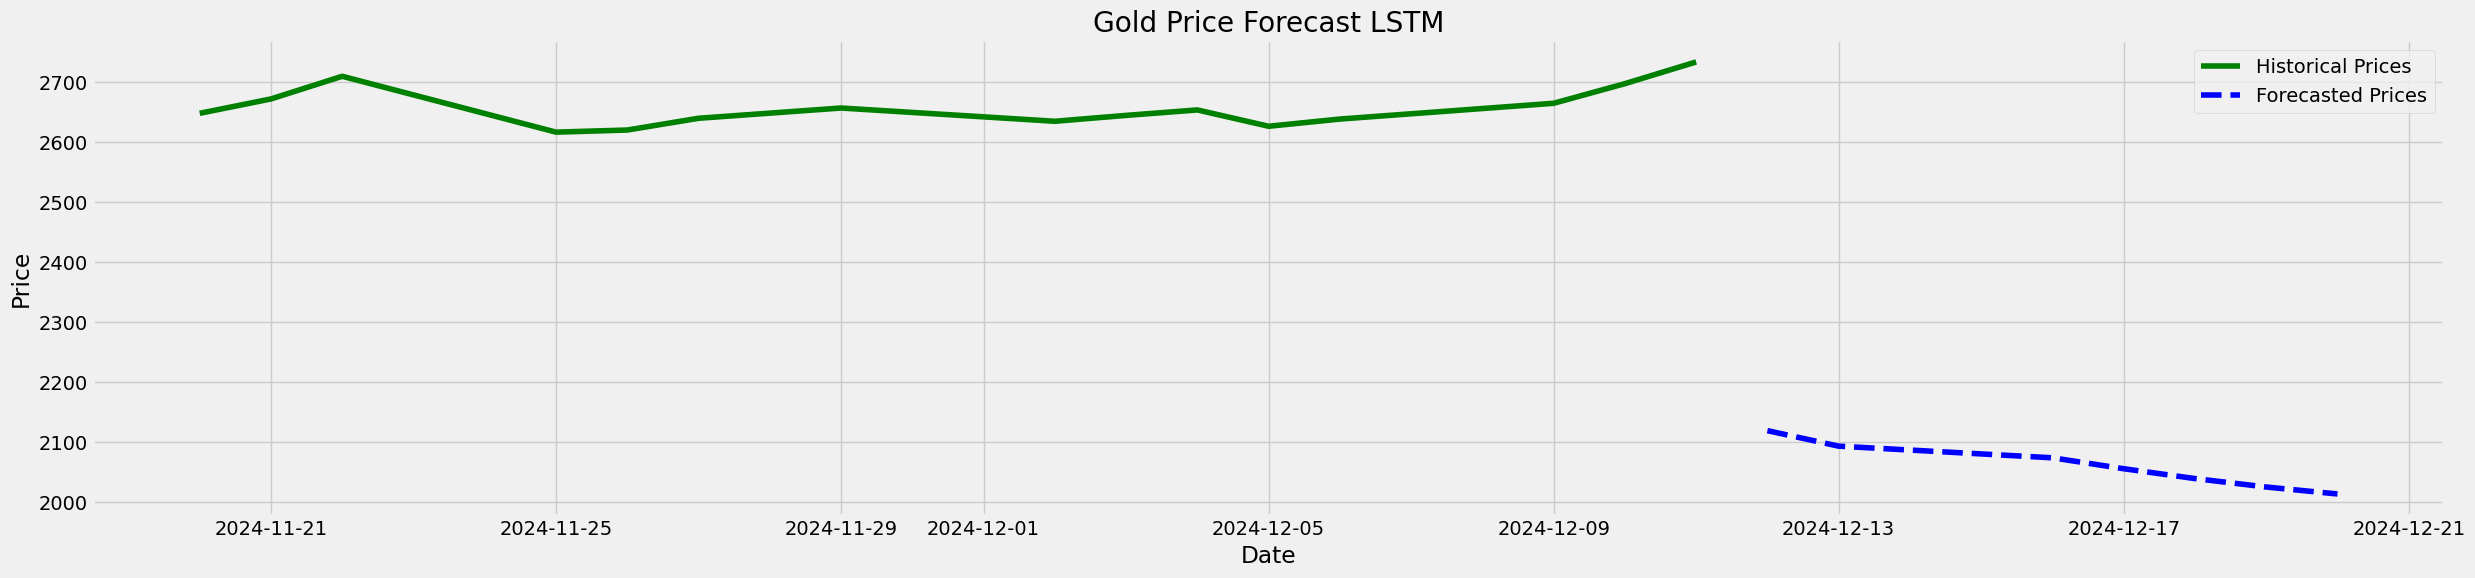

In [ ]:
plt.figure(figsize=(25, 6))

plt.plot(final_data.index[-15:], final_data['Close_GC=F'].values[-15:], label='Historical Prices', color='green')


plt.plot(future_dates, future_pred_lstm, label='Forecasted Prices', linestyle='--', color='blue')
plt.title('Gold Price Forecast LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(future_dates)

DatetimeIndex(['2024-12-12', '2024-12-13', '2024-12-16', '2024-12-17',
               '2024-12-18', '2024-12-19', '2024-12-20'],
              dtype='datetime64[ns]', freq='B')


In [ ]:

real_future_data = yf.download(tickers, start= '2024-12-12', end='2024-12-20', interval='1d')


[*********************100%***********************]  1 of 1 completed


In [ ]:
creating_features(real_future_data).head()

,Close_GC=F
Date,
2024-12-12,2687.500000
2024-12-13,2656.000000
2024-12-16,2651.399902
2024-12-17,2644.399902
2024-12-18,2636.500000
